In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from itertools import combinations
import tensorflow as tf


In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.LogicalDeviceConfiguration(memory_limit=1024)

LogicalDeviceConfiguration(memory_limit=1024, experimental_priority=None)

In [3]:
import tensorflow_datasets as tfds

In [21]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

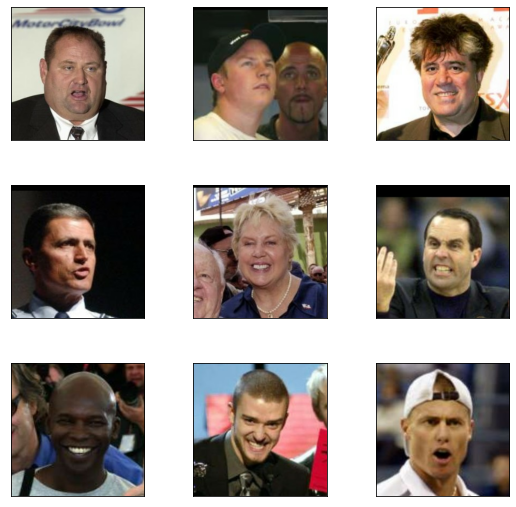

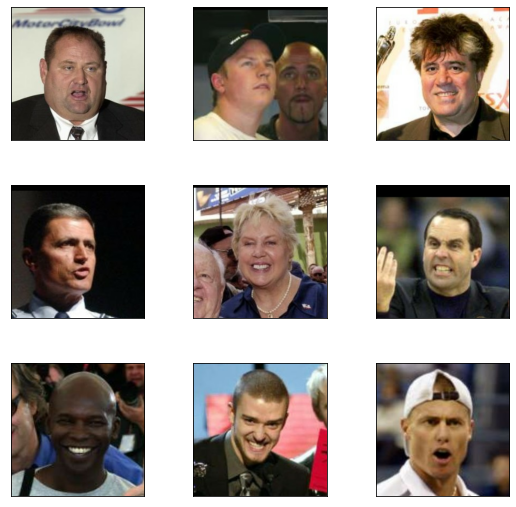

In [ ]:
tfds.visualization.show_examples(train_ds,ds_info)

In [22]:
def prepare(label,img):
    img = tf.cast(img, tf.float32)/255.
    # img=tf.image.rgb_to_grayscale(img)
    return tf.image.resize(img, (128, 128)),label

train_ds=train_ds.map(prepare)
test_ds=test_ds.map(prepare)
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.repeat(10)
train_ds = train_ds.batch(64, drop_remainder=True)
test_ds = test_ds.batch(64, drop_remainder=True)

In [6]:

weight_decay=0.001
wd=tf.keras.regularizers.L2(weight_decay)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [31]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=wd),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',kernel_regularizer=wd),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=wd),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [34]:
MARGIN = 5.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    p=tf.constant(d)
    z = tf.cast(labels1 == labels2, tf.float32)

    return  tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0,MARGIN- d)**2)

In [35]:
LEARNING_RATE = 0.000001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [36]:
%%time
v=[]
i=1
for iteration, (images, labels) in enumerate(train_ds):

    with tf.GradientTape() as tape:
        embs = model(images)

        loss_value = contastive_loss(embs, labels)
        
        v.append
        ((loss_value).numpy())

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if iteration % 100== 0:

        loss_value_temp=[]

        for (images, labels) in test_ds:
       
          embs = model(images)
          loss_value_test = contastive_loss(embs, labels)
          loss_value_temp.append(loss_value_test.numpy())

        print('[{}] Loss: {:.5f}, ValLoss: {:.5f}'.format(iteration, loss_value.numpy(), np.mean(loss_value_temp)))

[0] Loss: 22.93019, ValLoss: 22.81966
[100] Loss: 20.57264, ValLoss: 21.28667
[200] Loss: 19.44548, ValLoss: 19.27009
[300] Loss: 17.42036, ValLoss: 16.91942
[400] Loss: 15.14932, ValLoss: 14.34157
[500] Loss: 10.52715, ValLoss: 11.80379
[600] Loss: 8.79466, ValLoss: 9.54697
[700] Loss: 6.66660, ValLoss: 7.64390
[800] Loss: 5.61553, ValLoss: 5.89949
[900] Loss: 4.25022, ValLoss: 4.96510
[1000] Loss: 4.01870, ValLoss: 3.74595
[1100] Loss: 3.22397, ValLoss: 3.11700
[1200] Loss: 3.24282, ValLoss: 2.57703
[1300] Loss: 2.14709, ValLoss: 1.98433
[1400] Loss: 2.12590, ValLoss: 1.70101
[1500] Loss: 1.09767, ValLoss: 1.58928
[1600] Loss: 1.01780, ValLoss: 1.34325
[1700] Loss: 0.68343, ValLoss: 1.15061
[1800] Loss: 0.91183, ValLoss: 0.92142
CPU times: user 4min 19s, sys: 24.2 s, total: 4min 43s
Wall time: 7min 13s


In [62]:
images_backham = []

for batch, labels in test_ds:
    images = batch[labels==b'David_Beckham']

    images_backham+=(list(images))

In [64]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

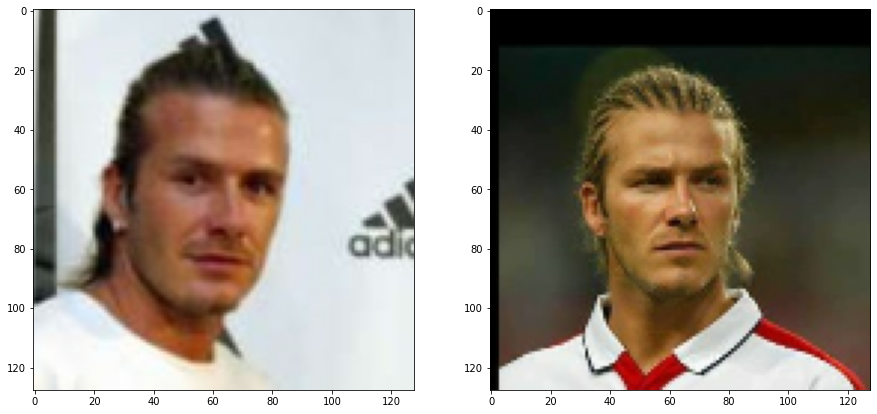

David_Beckham David_Beckham 1.7065


In [86]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(images_backham[0])
ax[1].imshow(images_backham[1])
plt.show()

emb_backham1 = model(images_backham[0][None])
emb_backham2 = model(images_backham[0][None])
print('David_Beckham','David_Beckham',round(diff(emb_backham1, emb_backham2), 4))

In [74]:
image_test=list(test_ds.take(1))[0][0][0]
label_test=list(test_ds.take(1))[0][1][0]

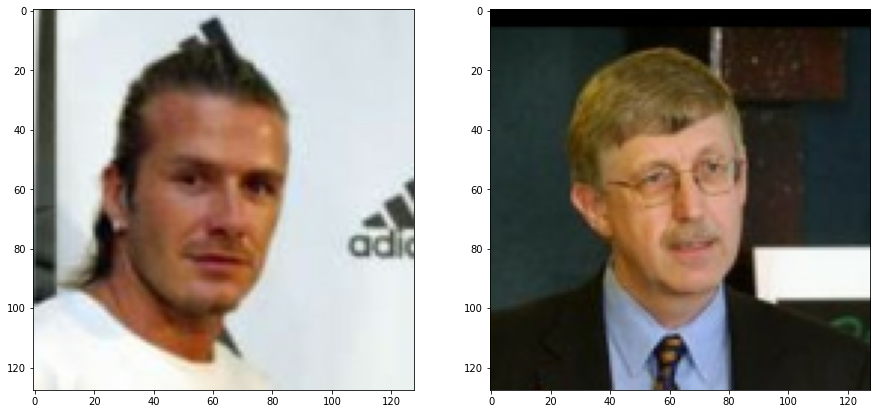

David_Beckham Francis_Collins 16.0516


In [87]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(images_backham[0])
ax[1].imshow(image_test)
plt.show()

emb_backham = model(images_backham[0][None])
emb_test = model(image_test[None])
print('David_Beckham',label_test.numpy().decode(),round(diff(emb1, emb2), 4))